# DCGan with skorch

Code is adapted from [pytorch examples](https://github.com/pytorch/examples/tree/master/dcgan)

## Imports

In [1]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils

In [3]:
from skorch import NeuralNet
from skorch.utils import noop
from skorch.callbacks import BatchScoring

/home/vinh/anaconda3/envs/skorch/lib/python3.6/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


## Parameters

In [4]:
torch.manual_seed(0)
device = torch.device("cuda:0") if torch.cuda.is_available() else 'cpu'

In [5]:
nz = 100  # size of the latent z vector
ngf = 32  # units of generator
ndf = 32  # units of discriminator
nc = 1  # number of channels
batch_size = 64
lr = 0.0002
beta1 = 0.5  # for adam
max_epochs = 25
ngpu = 1
img_size = 32  # 32 is easier than 28 to work with
workers = 2  # for dataloader

In [6]:
path = './mnist'

## Load data

In [7]:
dataset = dset.MNIST(
    root=path,
    download=True,
    transform=transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,)),
    ]),
)

## Custom code

In [9]:
# custom weights initialization called on generator and discriminator
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        m.weight.data.normal_(0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

In [10]:
class Generator(nn.Module):
    def __init__(self, nz, ngf, ngpu):
        super().__init__()
        self.nz = nz
        self.ngf = ngf
        self.ngpu = ngpu

        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(     nz, ngf * 4, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. (ngf*4) x 4 x 4
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. (ngf*2) x 8 x 8
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. (ngf) x 16 x 16
            nn.ConvTranspose2d(ngf,     nc, 4, 2, 1, bias=False),
            nn.Tanh(),
            # state size. (nc) x 32 x 32
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)
        return output

In [11]:
class Discriminator(nn.Module):
    def __init__(self, nc, ndf, ngpu):
        super().__init__()
        self.nc = nc
        self.ndf = ndf
        self.ngpu = ngpu

        self.main = nn.Sequential(
            # state size. (ndf) x 32 x 32
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 16 x 16
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 8 x 8
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 4 x 4
            nn.Conv2d(ndf * 4, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        if input.is_cuda and self.ngpu > 1:
            output = nn.parallel.data_parallel(self.main, input, range(self.ngpu))
        else:
            output = self.main(input)

        return output.view(-1, 1).squeeze(1)

In [12]:
class Dcgan(nn.Module):
    def __init__(self, nc, nz, ndf, ngf, ngpu):
        super().__init__()
        
        self.nc = nc
        self.nz = nz
        self.ndf = ndf
        self.ngf = ngf
        self.ngpu = ngpu

        self.discriminator = Discriminator(
            nc=self.nc,
            ndf=self.ndf,
            ngpu=self.ngpu,
        )
        self.discriminator.apply(weights_init)
        self.generator = Generator(
            nz=self.nz,
            ngf=self.ngf,
            ngpu=self.ngpu,
        )
        self.discriminator.apply(weights_init)
        
    def forward(self, X, y=None):
        # real data
        output_real = self.discriminator(X)

        # generated data
        noise = torch.randn(X.shape[0], self.nz, 1, 1, device=X.device)
        fake = self.generator(noise)
        output_fake = self.discriminator(fake)
        output_fake_det = self.discriminator(fake.detach())

        return output_real, output_fake, output_fake_det, fake

In [13]:
class DcganCriterion(nn.Module):
    def __init__(self, real_label=1, fake_label=0):
        super().__init__()
        self.criterion = nn.BCELoss()

    def forward(self, y_pred, y_true=None):
        output_real, output_fake, output_fake_det, _ = y_pred
        batch_size = len(output_real)
        device = output_real.device
        label_real = torch.ones((batch_size,),device=device)
        label_fake = torch.zeros((batch_size,),device=device)

        # discriminator real
        loss_discriminator_real = self.criterion(output_real, label_real)

        # discriminator fake
        loss_discriminator_fake = self.criterion(output_fake_det, label_fake)

        # generator
        loss_generator = self.criterion(output_fake, label_real)

        # return individual losses to log them separately
        return loss_discriminator_real, loss_discriminator_fake, loss_generator

### add in extra logging

The changes below are not strictly necessary, they are just there to log the discriminator and generator loss.

In [14]:
class DcganNet(NeuralNet):
    def get_loss(self, y_pred, y_true, X=None, training=False):
        loss_discriminator_real, loss_discriminator_fake, loss_generator = self.criterion_(y_pred, y_true)
        prefix = 'train_' if training else 'valid_'

        loss_discriminator = loss_discriminator_real + loss_discriminator_fake
        self.history.record_batch(prefix + 'dis', loss_discriminator.item())
        self.history.record_batch(prefix + 'gen', loss_generator.item())
        
        return loss_discriminator_real + loss_discriminator_fake + loss_generator

In [15]:
def train_loss_gen(net, X=None, y=None):
    return net.history[-1, 'batches', -1, 'train_gen']
def train_loss_dis(net, X=None, y=None):
    return net.history[-1, 'batches', -1, 'train_dis']

In [16]:
def valid_loss_gen(net, X=None, y=None):
    return net.history[-1, 'batches', -1, 'valid_gen']
def valid_loss_dis(net, X=None, y=None):
    return net.history[-1, 'batches', -1, 'valid_dis']

In [17]:
extra_callbacks = [
    ('train_loss_gen', BatchScoring(train_loss_gen, on_train=True, target_extractor=noop)),
    ('train_loss_dis', BatchScoring(train_loss_dis, on_train=True, target_extractor=noop)),
    ('valid_loss_gen', BatchScoring(valid_loss_gen, on_train=False, target_extractor=noop)),
    ('valid_loss_dis', BatchScoring(valid_loss_dis, on_train=False, target_extractor=noop)),
]

## Train net

In [18]:
net = DcganNet(
    Dcgan,
    module__nz=nz,
    module__ndf=ndf,
    module__ngf=ngf,
    module__nc=nc,
    module__ngpu=ngpu,

    criterion=DcganCriterion,
    optimizer=optim.Adam,
    lr=lr,
    optimizer__betas=(beta1, 0.999),
    batch_size=batch_size,
    max_epochs=max_epochs,

    train_split=False,  # comment out for internal train/valid split
    iterator_train__shuffle=True,
    iterator_train__num_workers=workers,
    iterator_valid__num_workers=workers,
    
    callbacks=extra_callbacks,
)

In [19]:
net.fit(dataset)

  epoch    train_loss    train_loss_dis    train_loss_gen       dur
-------  ------------  ----------------  ----------------  --------
      1        1.5962            0.9756            0.6206  359.4358
      2        1.6466            1.0542            0.5925  286.3734
      3        1.6066            0.9977            0.6089  281.0857
      4        1.5888            0.9710            0.6179  276.5708
      5        1.5427            0.8983            0.6443  284.5098
      6        1.5258            0.8704            0.6554  281.8785
      7        1.5147            0.8559            0.6588  280.2213
      8        1.4994            0.8325            0.6669  282.9186
      9        1.4996            0.8322            0.6674  276.6854
     10        1.4873            0.8156            0.6717  282.6022
     11        1.4643            0.7832            0.6811  274.0600
     12        1.4859            0.8149            0.6710  281.7605
     13        1.4707            0.7934         

<class '__main__.DcganNet'>[initialized](
  module_=Dcgan(
    (discriminator): Discriminator(
      (main): Sequential(
        (0): Conv2d(1, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): LeakyReLU(negative_slope=0.2, inplace=True)
        (5): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
        (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (7): LeakyReLU(negative_slope=0.2, inplace=True)
        (8): Conv2d(128, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
        (9): Sigmoid()
      )
    )
    (generator): Generator(
      (main): Sequential(
        (0): ConvTranspose2d(100, 128, kernel_size=(4, 4), stride=(1, 1), bias=Fal

## Inspect images

In [20]:
_, _, _, fake_imgs = net.forward(torch.utils.data.Subset(dataset, torch.arange(0, 10)))

In [21]:
fake_imgs.shape

torch.Size([10, 1, 32, 32])

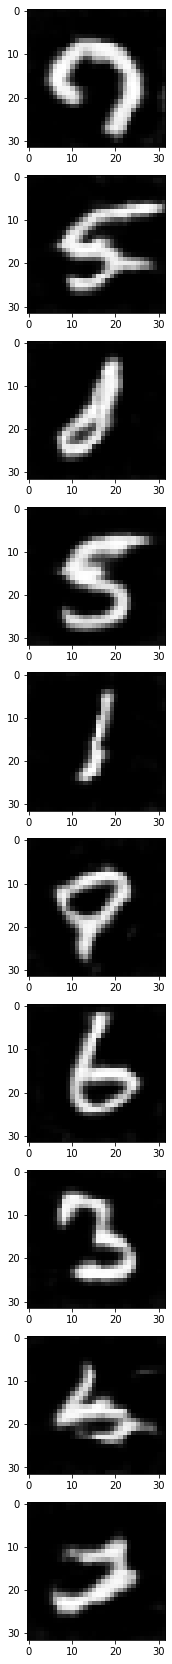

In [22]:
_, axes = plt.subplots(10, 1, figsize=(8, 30))
for i in range(10):
    axes[i].imshow(fake_imgs[i][0].numpy(), cmap='gray')